In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pickle

In [2]:
df = pd.read_csv('customer_churn.csv')

In [3]:
df.drop(columns=['customerID'], inplace=True)
df.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [4]:
df['TotalCharges'] = df['TotalCharges'].replace(' ','0.0').astype(float)

for col in df.columns:
    if df[col].dtype == object:
        print(col, df[col].unique())
        print("-"*50)


gender ['Female' 'Male']
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingM

In [5]:
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [6]:
def plot_histogram(df,column_name):
    plt.figure(figsize=(5,3))
    sns.histplot(df[column_name],kde=True)
    plt.title(f'Distribution of {column_name}')
    col_mean=df[column_name].mean()
    col_median=df[column_name].median()
    plt.axvline(col_mean,color='red',linestyle='--',label="Mean")
    plt.axvline(col_median,color='green',label='Median')
    plt.legend()
    plt.show()

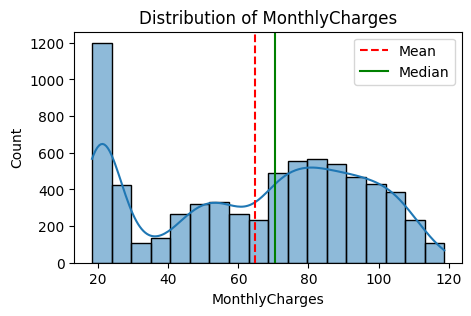

In [7]:
plot_histogram(df,'MonthlyCharges')

In [8]:
def plot_boxplot(df, column_name):
    plt.figure(figsize=(5,3))
    sns.boxplot(y=df[column_name])
    plt.title(f'Boxplot of {column_name}')
    plt.ylabel(column_name)
    plt.show()

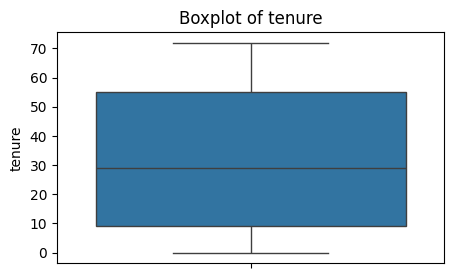

In [9]:
plot_boxplot(df,'tenure')

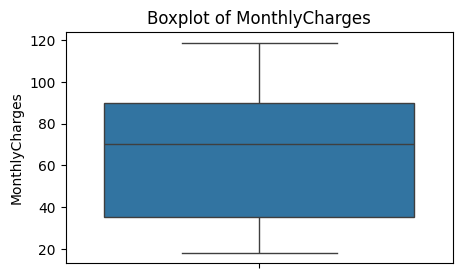

In [10]:
plot_boxplot(df,'MonthlyCharges')

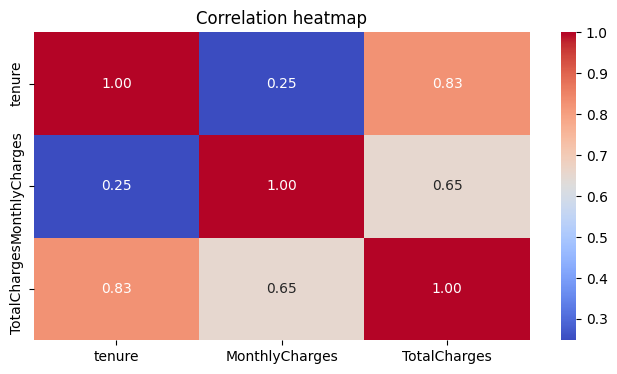

In [11]:
plt.figure(figsize=(8,4))
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges']].corr(), annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation heatmap')
plt.show()

In [12]:
categorical_columns=df.select_dtypes(include='object').columns.to_list()
categorical_columns.append('SeniorCitizen')

In [13]:
numerical_columns=df.select_dtypes(exclude='object').columns.to_list()

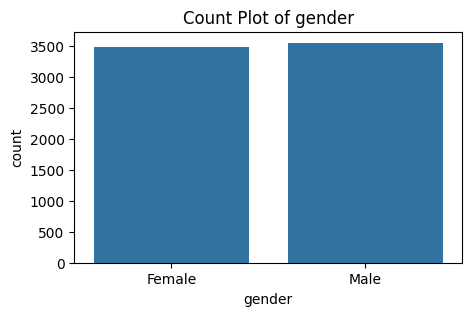

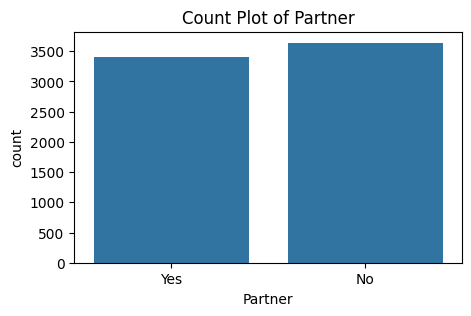

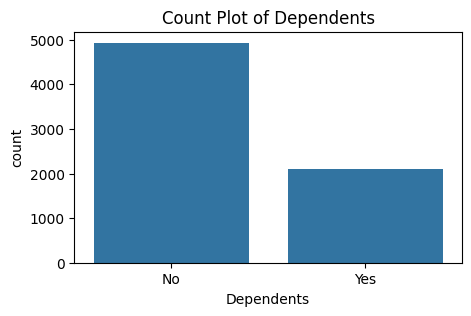

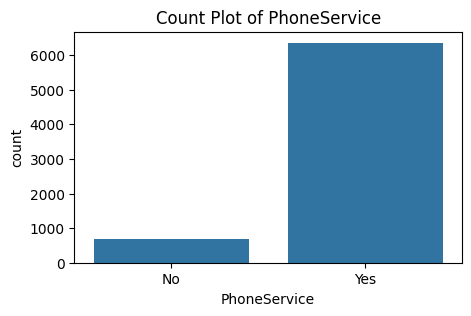

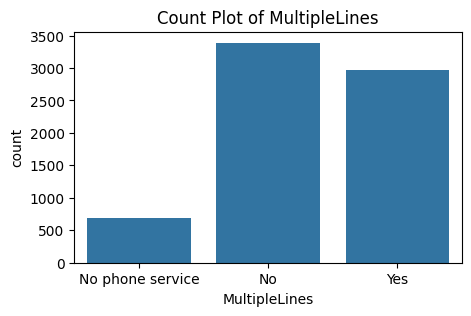

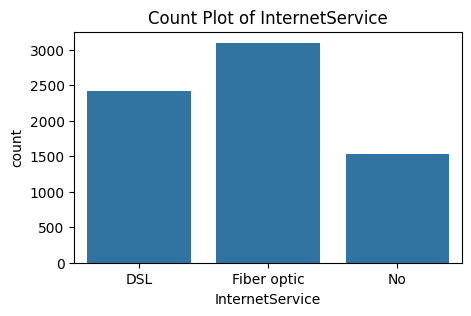

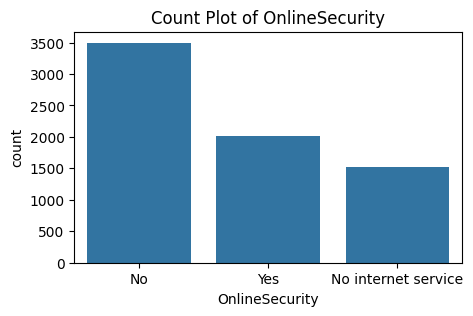

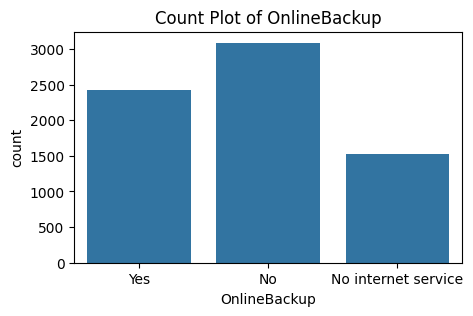

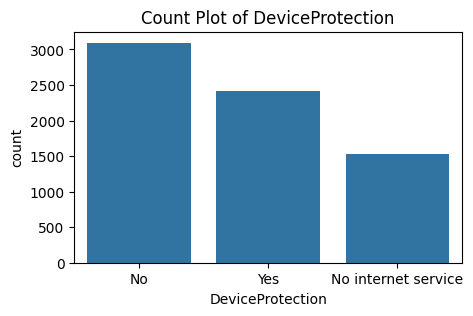

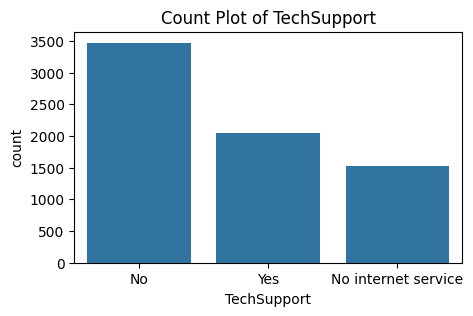

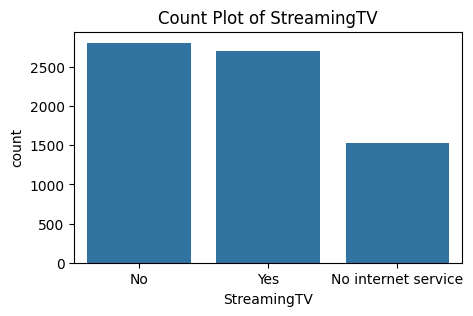

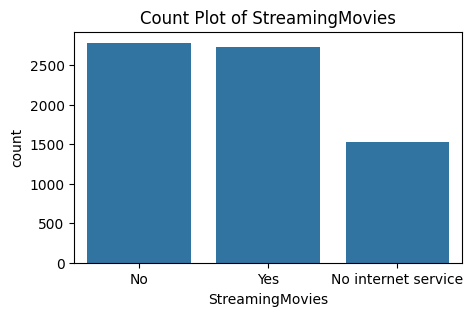

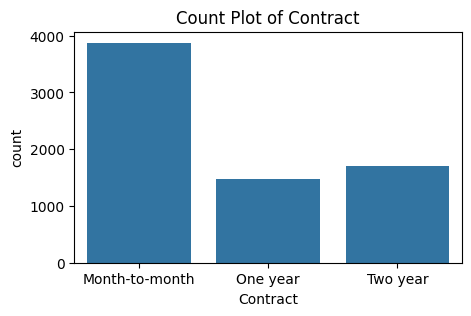

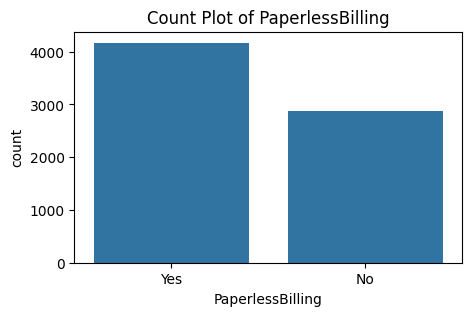

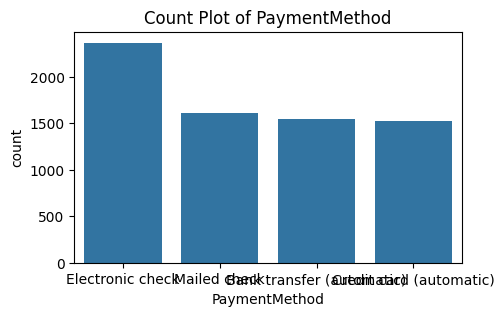

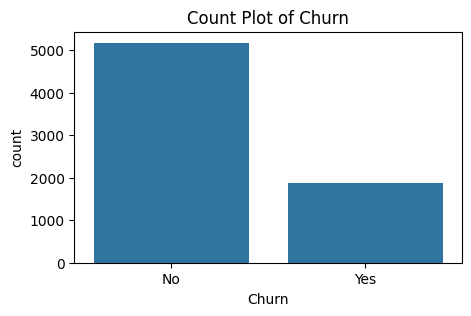

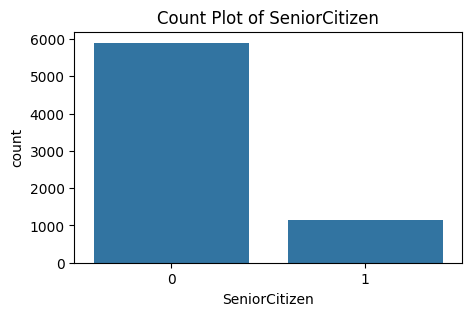

In [14]:
for col in categorical_columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df[col])
    plt.title(f"Count Plot of {col}")
    plt.show()

In [15]:
df.Churn=df.Churn.map({'Yes':1,'No':0})

In [16]:
df.Churn.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [17]:
encoder={}
for column in categorical_columns:
    label_encoder=LabelEncoder()
    df[column]=label_encoder.fit_transform(df[column])
    encoder[column]=label_encoder
with open('encoder.pkl','wb') as f:
    pickle.dump(encoder,f)    

In [18]:
X= df.drop(columns=['Churn'])
Y=df["Churn"]

In [19]:
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.2, random_state=42)

In [20]:
smote=SMOTE(random_state=42)


In [21]:
X_train_smote,Y_train_smote= smote.fit_resample(X_train,Y_train)

In [33]:
models={
    "Descision tree":DecisionTreeClassifier(random_state=42),
    "Random Forest":RandomForestClassifier(random_state=42),
    "XGBoost":XGBRFClassifier(random_state=42)
}

In [37]:
cv_scores={}

for model_name, model in models.items():
    print(f'Training {model_name} with default parameters')
    score=cross_val_score(model, X_train_smote,Y_train_smote,cv=5,scoring='accuracy')
    cv_scores[model_name]=score 
    print(f'{model_name} cross validation accuracy : {np.mean(score):.2f}')

Training Descision tree with default parameters
Descision tree cross validation accuracy : 0.78
Training Random Forest with default parameters
Random Forest cross validation accuracy : 0.84
Training XGBoost with default parameters
XGBoost cross validation accuracy : 0.81


In [40]:
model=RandomForestClassifier(random_state=42)

In [41]:
model.fit(X_train_smote,Y_train_smote)

RandomForestClassifier(random_state=42)

In [42]:
y_test_pred = model.predict(X_test)

print("Accuracy Score:\n", accuracy_score(Y_test, y_test_pred))
print("Confsuion Matrix:\n", confusion_matrix(Y_test, y_test_pred))
print("Classification Report:\n", classification_report(Y_test, y_test_pred))

Accuracy Score:
 0.7771469127040455
Confsuion Matrix:
 [[880 156]
 [158 215]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.58      0.58       373

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create base model
base_model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=50,  # You can increase this number for better results
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Uses all cores
    scoring='accuracy'
)

# Fit to SMOTE training data
random_search.fit(X_train_smote, Y_train_smote)

# Get best model
best_model = random_search.best_estimator_

# Predict on test data
y_test_pred = best_model.predict(X_test)

# Evaluation
print("Best Hyperparameters:\n", random_search.best_params_)
print("\nAccuracy Score:\n", accuracy_score(Y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_test_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\somuv\miniconda3\envs\mlenv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
115 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
79 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\somuv\miniconda3\envs\mlenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\somuv\miniconda3\envs\mlenv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\somuv\miniconda3\envs\mlenv\Lib\site-packages\sk

Best Hyperparameters:
 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}

Accuracy Score:
 0.7849538679914834

Confusion Matrix:
 [[881 155]
 [148 225]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      1036
           1       0.59      0.60      0.60       373

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.73      1409
weighted avg       0.79      0.78      0.79      1409



In [46]:
best_model

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_split=10, n_estimators=500, random_state=42)

In [47]:
# save the trained model as a pickle file
model_data = {"model": best_model, "features_names": X.columns.tolist()}


with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(model_data, f)

In [48]:
with open("customer_churn_model.pkl", "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["features_names"]

In [51]:
feature_names

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [52]:
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}


input_data_df = pd.DataFrame([input_data])

with open("encoder.pkl", "rb") as f:
  encoders = pickle.load(f)


# encode categorical featires using teh saved encoders
for column, encoder in encoders.items():
  if column == "Churn":
      continue  
  input_data_df[column] = encoder.transform(input_data_df[column])

# make a prediction
prediction = loaded_model.predict(input_data_df)
pred_prob = loaded_model.predict_proba(input_data_df)

print(prediction)

# results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {pred_prob}")

[0]
Prediction: No Churn
Prediciton Probability: [[0.62508968 0.37491032]]


In [56]:
encoders.pop('Churn')

LabelEncoder()